In [3]:
###Import packages###

import requests
import SPOT_API
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import folium
from folium.plugins import MarkerCluster
import time
import haversine
from haversine import haversine, Unit
from folium import plugins
import warnings
warnings.filterwarnings('ignore')
#!pip install -U folium
#!pip install haversine
#!pip install geopy
#!pip install folium

In [2]:
###Pull data from API
###function takes in the Feed ID, by default it takes in one of the test Feed IDs.
locationdf = SPOT_API.access_XML_API()


In [17]:
#Clean up data
locationdf['Latitude'] = pd.to_numeric(locationdf['Latitude'])
locationdf['Longitude'] = pd.to_numeric(locationdf['Longitude'])
locationdf['Unixtime'] = pd.to_numeric(locationdf['Unixtime'])


In [57]:
###Find maximum, minimum and mean drift speeds for each spot device

for messenger in set(locationdf.MessengerName):
    tempdf = locationdf.loc[locationdf['MessengerName'] == f'{messenger}']
    
    ###Create lag - 1 columns for latitude, longitude, and time
    
    tempdf['Latitude_shift'] = tempdf.Latitude.shift(1)
    tempdf['Longitude_shift'] = tempdf.Longitude.shift(1)
    tempdf['timediff'] = (tempdf.Unixtime.shift(1) - tempdf.Unixtime)/(60*60)
    
    ###Translate coordinate points in to distance in miles
    
    tempdf['distancediff'] = tempdf.apply(
    (lambda row: haversine(
    (row['Latitude'], row['Longitude']),
    (row['Latitude_shift'], row['Longitude_shift'])
    )),
    axis=1
    )

    ###Print out results
    
    print(f'For Spot Device {messenger} the max, min, and mean drift speeds in miles per hour are: ')
    print(np.nanmax(tempdf.distancediff/tempdf.timediff))
    print(np.nanmin(tempdf.distancediff/tempdf.timediff))
    print(np.nanmean(tempdf.distancediff/tempdf.timediff))
    print('---------------')


For Spot Device A the max, min, and mean drift speeds in miles per hour are: 
0.026040971967863747
0.0
0.008575416748647181
---------------
For Spot Device E the max, min, and mean drift speeds in miles per hour are: 
0.02701824302654772
0.00022265096429255706
0.007071974095997128
---------------


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001876F901828>,
      dtype=object)

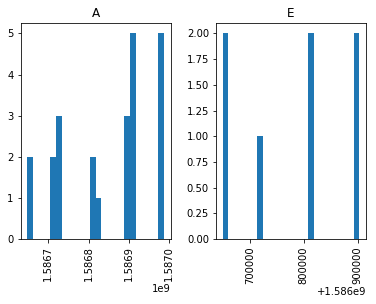

In [56]:
##########Plot the number of updates daily in 30 minute intervals####


##Find out what time it is when the script is called
current_time = time.time()

##Find out how many updates occurred within 24 hours = 86,400 seconds
tempdf = locationdf.loc[(locationdf['Unixtime']< current_time) & (locationdf['Unixtime']>(current_time-86400))]

###Plot histogram of updates in 30 minute intervals
###This plot will give an error right now because there are no updates in the test API in the past day.

tempdf.Unixtime.hist(by=tempdf.MessengerName, bins=24)


In [25]:
####Create a map of the SPOT device locations#####

####Center the map on the SPOT devices
map_center = (np.mean(locationdf['Latitude']),np.mean(locationdf['Longitude']))

###Initialize map
m = folium.Map(location = map_center, zoom_start = 12)
fg = folium.FeatureGroup(name = 'Devices')

messengers = []
groups = []
paths=dict()

####Find out how many devices are active
for i in set(locationdf.MessengerName):
    groups.append(plugins.FeatureGroupSubGroup(fg, f'Spot Device {i}'))
    messengers.append(f'{i}')
    paths[i] = []
                 

###Parse out the locations that each device went to, add locations to map    
for i in locationdf.iterrows():
    paths[i[1]['MessengerName']].append(([i[1]['Latitude'],i[1]['Longitude']]))
    folium.Marker(
             location = [i[1]['Latitude'],i[1]['Longitude']]).add_to(groups[list(set(locationdf.MessengerName)).index(i[1]['MessengerName'])])

###Create sublayers so that you can select for individual devices on the map
m.add_child(fg)
for item in range(len(groups)):
    m.add_child(groups[item])
    
folium.LayerControl(collapsed=False).add_to(m)



###Create the paths for each device 
for i in paths:
    folium.PolyLine(locations = paths[i], 
                     line_opacity = 0.3).add_to(m) 

###Display map
m

In [ ]:
#####Exploratory coding to see how the mapping package works, can just ignore for now###
from folium import plugins
map_center = (np.mean(locationdf['Latitude']),np.mean(locationdf['Longitude']))
m = folium.Map(location = map_center, zoom_start = 12)

# mcg = folium.plugins.MarkerCluster(control=False)
# m.add_child(mcg)
fg = folium.FeatureGroup(name = 'Devices')
m.add_child(fg)
g1 = plugins.FeatureGroupSubGroup(fg, 'Spot Device A')
m.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'Spot Device E')
m.add_child(g2)

pathA=[]
pathE=[]

for i in locationdf.iterrows():
    if i[1]['MessengerName'] == 'A':
        pathA.append(([i[1]['Latitude'],i[1]['Longitude']]))
        folium.Marker(
            location = [i[1]['Latitude'],i[1]['Longitude']]).add_to(g1)
    elif i[1]['MessengerName'] == 'E':
        pathE.append(([i[1]['Latitude'],i[1]['Longitude']]))        
        folium.Marker(
            location = [i[1]['Latitude'],i[1]['Longitude']]).add_to(g2)    
        


folium.LayerControl(collapsed=False).add_to(m)


#Path of Device A  
folium.PolyLine(locations = [pathA], 
                line_opacity = 0.3).add_to(m) 

#Path of Device E
folium.PolyLine(locations = [pathE], 
                line_opacity = 0.3).add_to(m)

m


In [ ]:
#####Exploratory coding to see how the mapping package works
from folium import plugins
map_center = (np.mean(locationdf['Latitude']),np.mean(locationdf['Longitude']))
m = folium.Map(location = map_center, zoom_start = 12)

# mcg = folium.plugins.MarkerCluster(control=False)
# m.add_child(mcg)
fg = folium.FeatureGroup(name = 'Devices')
m.add_child(fg)
g1 = plugins.FeatureGroupSubGroup(fg, 'Spot Device A')
m.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'Spot Device E')
m.add_child(g2)

pathA=[]
pathE=[]

for i in locationdf.iterrows():
    if i[1]['MessengerName'] == 'A':
        pathA.append(([i[1]['Latitude'],i[1]['Longitude']]))
        folium.Marker(
            location = [i[1]['Latitude'],i[1]['Longitude']]).add_to(g1)
    elif i[1]['MessengerName'] == 'E':
        pathE.append(([i[1]['Latitude'],i[1]['Longitude']]))        
        folium.Marker(
            location = [i[1]['Latitude'],i[1]['Longitude']]).add_to(g2)    
        


folium.LayerControl(collapsed=False).add_to(m)


#Path of Device A  
folium.PolyLine(locations = [pathA], 
                line_opacity = 0.3).add_to(m) 

#Path of Device E
folium.PolyLine(locations = [pathE], 
                line_opacity = 0.3).add_to(m)

m


In [ ]:
#####Exploratory coding to see how the mapping package works
from folium import plugins
map_center = (np.mean(locationdf['Latitude']),np.mean(locationdf['Longitude']))
m = folium.Map(location = map_center, zoom_start = 12)

# mcg = folium.plugins.MarkerCluster(control=False)
# m.add_child(mcg)
fg = folium.FeatureGroup(name = 'Devices')
m.add_child(fg)
g1 = plugins.FeatureGroupSubGroup(fg, 'Spot Device A')
m.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'Spot Device E')
m.add_child(g2)

pathA=[]
pathE=[]

for i in locationdf.iterrows():
    if i[1]['MessengerName'] == 'A':
        pathA.append(([i[1]['Latitude'],i[1]['Longitude']]))
        folium.Marker(
            location = [i[1]['Latitude'],i[1]['Longitude']]).add_to(g1)
    elif i[1]['MessengerName'] == 'E':
        pathE.append(([i[1]['Latitude'],i[1]['Longitude']]))        
        folium.Marker(
            location = [i[1]['Latitude'],i[1]['Longitude']]).add_to(g2)    
        


folium.LayerControl(collapsed=False).add_to(m)


#Path of Device A  
folium.PolyLine(locations = [pathA], 
                line_opacity = 0.3).add_to(m) 

#Path of Device E
folium.PolyLine(locations = [pathE], 
                line_opacity = 0.3).add_to(m)

m


In [28]:
import os
m.save('index.html')